## 第十五周: 字詞向量

**Author:** 劉岱宜<br>
**Date created:** 2021/10/01<br>
**Last modified:** 2021/11/17<br>

本周課程為「字詞向量」，我們將介紹將文字轉向量的方式來建立word2vec model，以計算文字間的相似度、文件分群、觀察視覺化的字詞關係等等。在本章我們使用BERT獲取文章中到字詞向量，藉以分類Google Play app 的英文評論資料。

## 大綱
1. 套件說明
2. 資料前處理
    + 2.1 處理情緒標籤
    + 2.2 文字格式轉換
    + 2.3 正式處理訓練資料
3. BERT 模型
    + 3.1 下載BERT預訓練模型
    + 3.2 定義完整模型與訓練、驗證流程
    + 3.3 迭代訓練模型
4. 查看模型結果
    + 4.1 檢視總體訓練結果
    + 4.2 個別句子的預測分析

## 學習目標
分析主題：用BERT將Google Play App的評論文集做向量建模，藉以分類評論文集情緒。
+ 資料內容：
    + 內容：Google play對App的評論資料
    + 使用欄位：
        + `content`: 評論內容
        + `sentiment`: 評論情緒標籤
1. 如何建構一個完整的BERT模型
    +  討論章節：
        2. 資料前處理
        3. BERT 模型
2. 什麼樣的類別預測的效果較好？
    + 討論章節：
        4. 查看模型結果

## 1. 套件說明
下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- spaCy: 自然語言處理工具。
- sklearn: 全名為Scikit-learn，機器學習的常用建模套件，包含各種分群、分類、迴歸模型，如隨機森林、SVM或 K-means 等。
- seaborn: 基於 matplotlib 封裝的繪圖工具
- time: 獲得目前的時間或作時間格式轉換的工具
- transformers: 本單元的重要套件，由hugging face開發，可以呼叫各種深度學習的訓練模型與訓練函數
- torch: 支持深度學習中多維度計算的套件

指定版本
- `numpy=1.17`

In [1]:
# !pip install numpy==1.17
# !pip install transformers -U
# !pip install -q -U watermark
# %reload_ext watermark
# %watermark -v -p numpy,pandas,torch,transformers

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
from time import time  # To time our operations

from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

+ 查看notebook運行環境（[nvidia 參數說明](https://blog.csdn.net/C_chuxin/article/details/82993350#:~:text=nvidia%2Dsmi%E6%98%AFnvidia%20%E7%9A%84,(%E5%A6%82ECC%20%E5%86%85%E5%AD%98%E5%8A%9F%E8%83%BD)%E3%80%82)）

In [3]:
!nvidia-smi

Fri Dec 31 19:22:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.00    Driver Version: 470.82.00    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 25%   33C    P8    19W / 260W |     22MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 24%   

+ 基本參數設定
    + seaborn畫圖參數（[參考連結](https://seaborn.pydata.org/tutorial/color_palettes.html)）
    + 深度學習參數：隨機變數、GPU環境

In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

# 設定畫圖背景樣式、調色盤樣式、字型大小
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
# 設定調色盤顏色
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
# 設定畫布大小
rcParams['figure.figsize'] = 12, 8

# 設定隨機變數
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
# 設定使用 GPU（第0張）
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## 2. 資料前處理
`reviews.csv`裡面包含了要分析的評論資料，在這邊我們先進行資料的基本檢視。

In [5]:
# 下載所需資料 reviews.csv
# !gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

In [6]:
df = pd.read_csv("raw_data/reviews.csv")
print(f"資料筆數: {df.shape[0]}, 資料欄位: {df.shape[1]}")
df.head(3)

資料筆數: 15746, 資料欄位: 11


,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo


### 2.1 處理情緒標籤
+ 檢視資料集基本資訊
    + 查看資料欄位、筆數
+ 處理資料標籤
    + 統計預測欄位、轉換情緒標籤

In [7]:
# 檢視資料基本資訊
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


+ 觀察評論分數分布
    + 發現除了分數3外，其他分數都分布的很平均

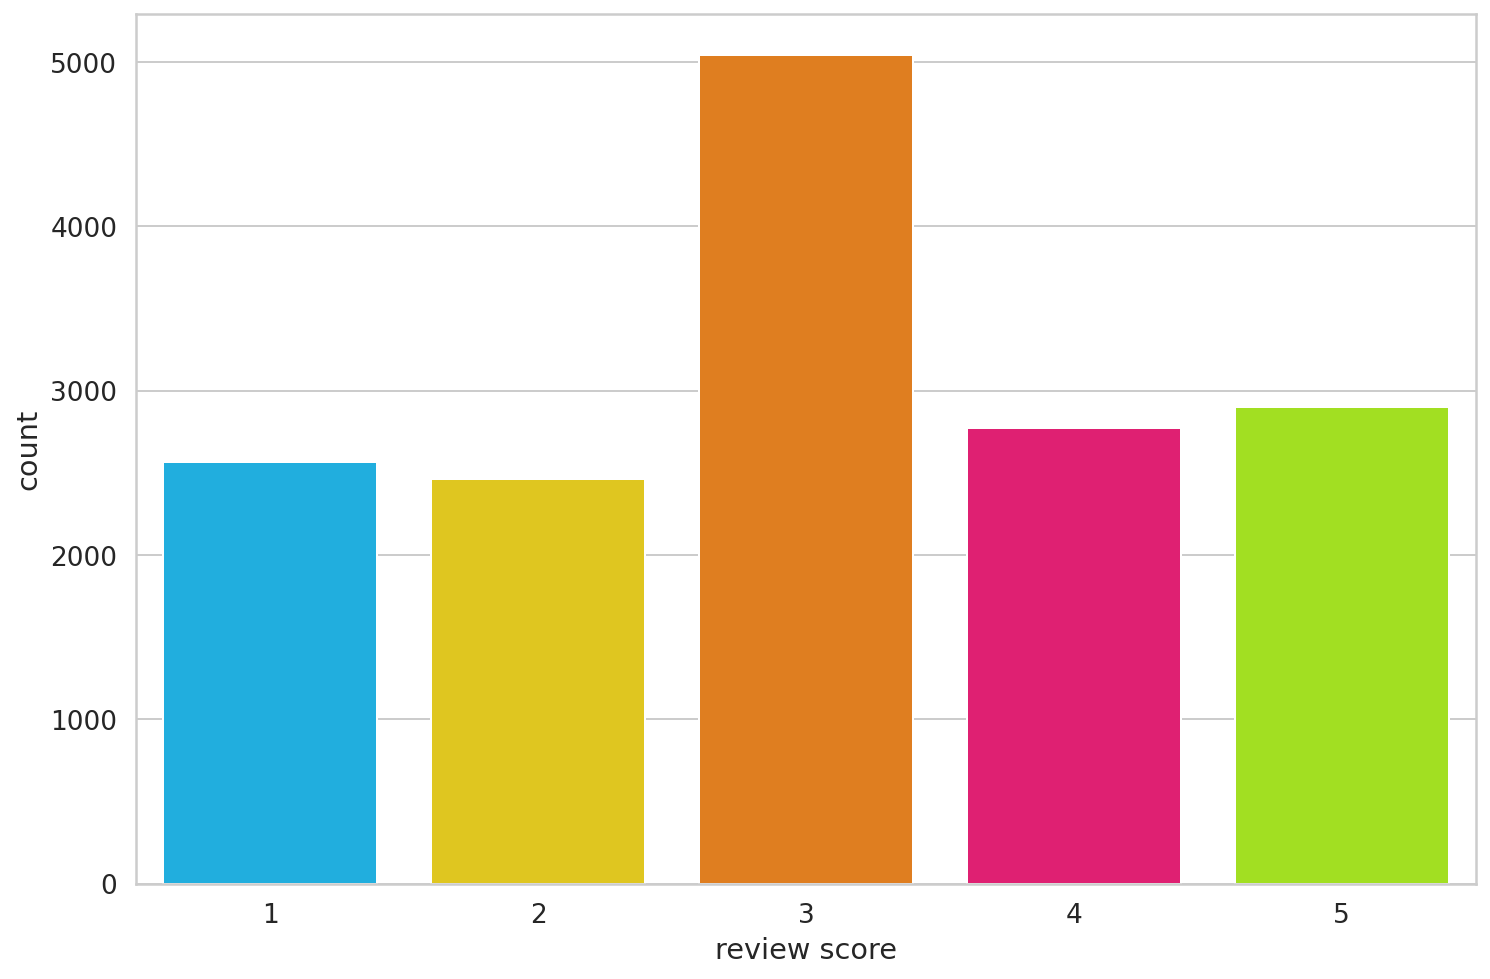

In [8]:
sns.countplot(df.score)
plt.xlabel('review score');

為了將評論分數分類，我們將分數小於2的評論分類為負面情緒；分數3的分類為中性情緒；分數超過3的分類為正面

In [9]:
def to_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else: 
        return 2

df['sentiment'] = df.score.apply(to_sentiment)

我們將評論分數score轉換成sentiment欄位後，看一下各情緒的筆數分布

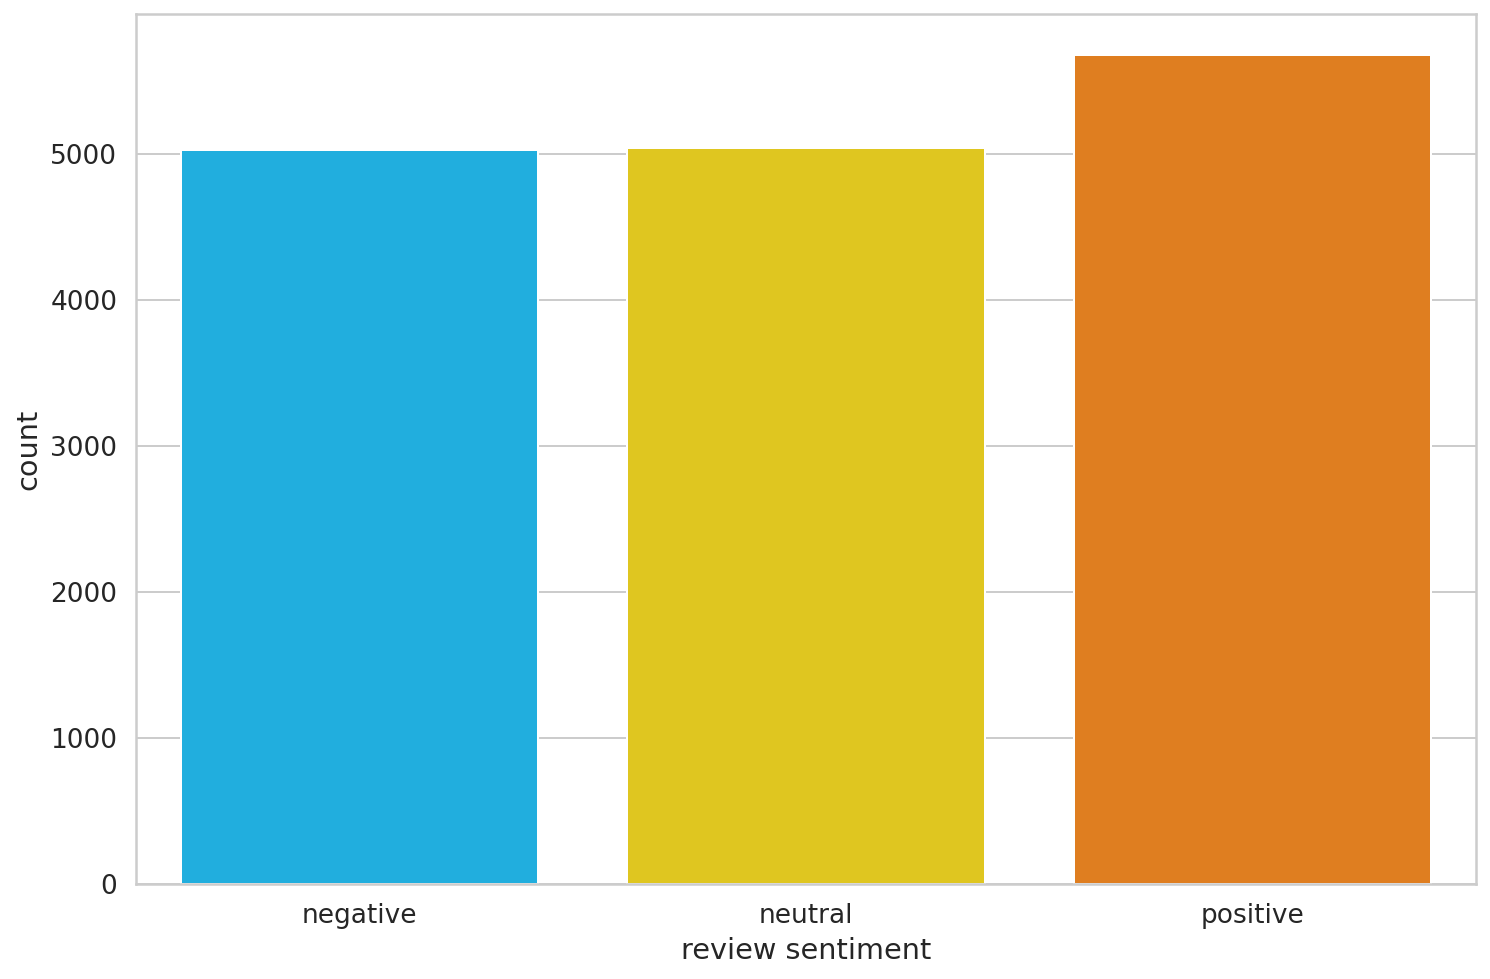

In [10]:
# 幫圖的x軸從左至右加上標籤
class_names = ['negative', 'neutral', 'positive']

# 畫圖
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

### 2.2 文字格式轉換
在這邊我們需要將評論資料轉換為BERT可以接受的格式，因為每個預訓練模型的格式都不太一樣，需要先選擇使用的模型，方便後續進行的模型格式轉換。

### 定義預訓練模型
+ 統計完資料集後，接下來要定義模型的部分，因為BERT 訓練十分耗時，可以利用hugging face上已經訓練好的 模型(pre-trained mdel)來做建模。同學可以嘗試不同模型的效果，在這裡使用會區分大小寫的 `bert-base-cased` 模型，因為在情緒表達上，大寫通常代表比較強烈的情緒，如`GOOD`通常比`good`有更強烈的意思。
+ 參考連結
    + [預訓練模型](https://huggingface.co/models)
    + [BERT 文件](https://huggingface.co/docs/transformers/model_doc/bert)

In [11]:
# 指定預訓練模型種類
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [12]:
# 定義 tokenizer (處理句子的模式)
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

### 文字格式轉換
在將訓練資料丟入模型前，我們需要用`tokenizer`將資料處理成BERT可以理解的格式，`tokenizer`的處理，大概可以分為三個部分。

1. 在句子加上特殊的 `tokens` 當作標記
    + `[CLS]`、`[SEP]`、`[PAD]`、`[UNK]`
2. 將句子截斷至固定的長度
    + `padding`
3. 加上模型需要注意的位置標記
    + `attention mask`: 有字的地方標記為1(real token)、沒有字的地方標記為0(pad token)

### 例句示範
+ 字詞的ID
    + `tokenizer` 會斷開句子中的每個詞和符號，並標上預訓練字典中獨特的ID。在這裡我們可以看到因為我們用的是會區分大小寫的模型，所以兩個My和my的ID是不一樣的，另外兩個位置的friend，因為是同樣的字，會有同樣的ID。
+ 句子的特殊標記
    + `[CLS]`：加在每句話的開頭
    + `[SEP]`：加在每句話的結尾
    + `[PAD]`：句子中的間隔
    + `[UNK]`：代替預訓練資料集中沒有出現過的字

In [13]:
sample_txt = 'My my dear friends. Together friends forever.' # 範例句子
tokens = tokenizer.tokenize(sample_txt) # 切開的詞
token_ids = tokenizer.convert_tokens_to_ids(tokens) # 詞的ID

print(f'Sentence: {sample_txt}\n')
print(f'Tokens: {tokens}')
print(f'Token IDs: {token_ids}\n')

# 查看tokenizer中的設定
print(f'start marker: {tokenizer.cls_token}, id {tokenizer.cls_token_id}')  # 句子的開頭
print(f'end marker: {tokenizer.sep_token}, id {tokenizer.sep_token_id}')  # 句子的結尾
print(f'padding marker: {tokenizer.pad_token}, id {tokenizer.pad_token_id}')  # padding
print(f'unknown marker: {tokenizer.unk_token}, id {tokenizer.unk_token_id}')  # 不知道的詞

Sentence: My my dear friends. Together friends forever.

Tokens: ['My', 'my', 'dear', 'friends', '.', 'Together', 'friends', 'forever', '.']
Token IDs: [1422, 1139, 7059, 2053, 119, 6333, 2053, 5221, 119]

start marker: [CLS], id 101
end marker: [SEP], id 102
padding marker: [PAD], id 0
unknown marker: [UNK], id 100


### encode_plus 函數處理
可以利用 encode_plus 這個函數，直接將整個句子 encode（[文件連結](https://huggingface.co/docs/transformers/main_classes/tokenizer)），最終一句話會產出兩種格式送入模型，分別是`input_ids`（每個不同的字、開頭結尾等）、`attention_mask`（模型要關注的位置）。

encode_plus的參數設定。
+ `max_length`: 一句話的最大長度，如果句子長度超過就會截斷，不足的話就用`[PAD]`補上
+ `add_special_tokens`：加上開頭和結尾標記
+ `return_token_type_ids`：回傳token id
+ `padding`：padding的方式，`max_length`是依據上面的參數設定的長度
+ `return_attention_mask`：回傳attention的結果
+ `return_tensors`：回傳的資料格式

In [14]:
encoding = tokenizer.encode_plus(
  sample_txt, # 我們上面定義的句子
  max_length=32,
  padding='max_length',
  truncation=True,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

# 可以將 encode 值取出來的key
print(f"type of encode: {type(encoding)}")
encoding.keys()

type of encode: <class 'transformers.tokenization_utils_base.BatchEncoding'>


dict_keys(['input_ids', 'attention_mask'])

### 查看encode之後的結果
用上面找到的`key`把encode之後的值取出來
+ `encode token id`
    + 可以看到我們上面選擇了區分大小寫的模型，所以`My`、`my`兩個字的ID會不一樣，如果像`friends`字完全相同，ID就會一樣
+ `attention mask`
    + 而如果句子長度不足`max_length`的地方會補0，有字的地方`attention mask`會是1，其餘是0。

In [15]:
# 查看 encode之後的結果
print(f"{sample_txt}")
# encode後句子的長度
print(f"sentence length after encoding: {len(encoding['input_ids'][0])}\n") 

encode_token = tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]) # 將ID轉換回token
encode_tokenID = encoding['input_ids'][0]
encode_attention = encoding['attention_mask'][0]

print(f"encode tokens:\n {encode_token}") # encode後的 token 
print(f"encode token id:\n {encode_tokenID}") # encode後的 token ID
print(f"attention mask:\n {encode_attention}") # encode後的 attention mask

My my dear friends. Together friends forever.
sentence length after encoding: 32

encode tokens:
 ['[CLS]', 'My', 'my', 'dear', 'friends', '.', 'Together', 'friends', 'forever', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
encode token id:
 tensor([ 101, 1422, 1139, 7059, 2053,  119, 6333, 2053, 5221,  119,  102,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])
attention mask:
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


### 2.3 正式處理訓練資料
接下來正式進行訓練資料的轉換，我們先檢視句子的基本長度、再將所有的評論切分為訓練、驗證集和測試集。

### 查看資料句子長度
在把資料轉換為BERT可以用的形式前，需要決定一個句子最大的長度該訂多少，先檢視一下資料集裡面句子的長度，將分布畫出來後，可以發現大部分的句子都集中在160個字左右，我們將max length訂為160。

In [16]:
# 計算資料集中句子的長度
token_lens = [] # 存所有句子的長度
for txt in df.content:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True) # 將句子斷開，限定最大長度為512
    token_lens.append(len(tokens))

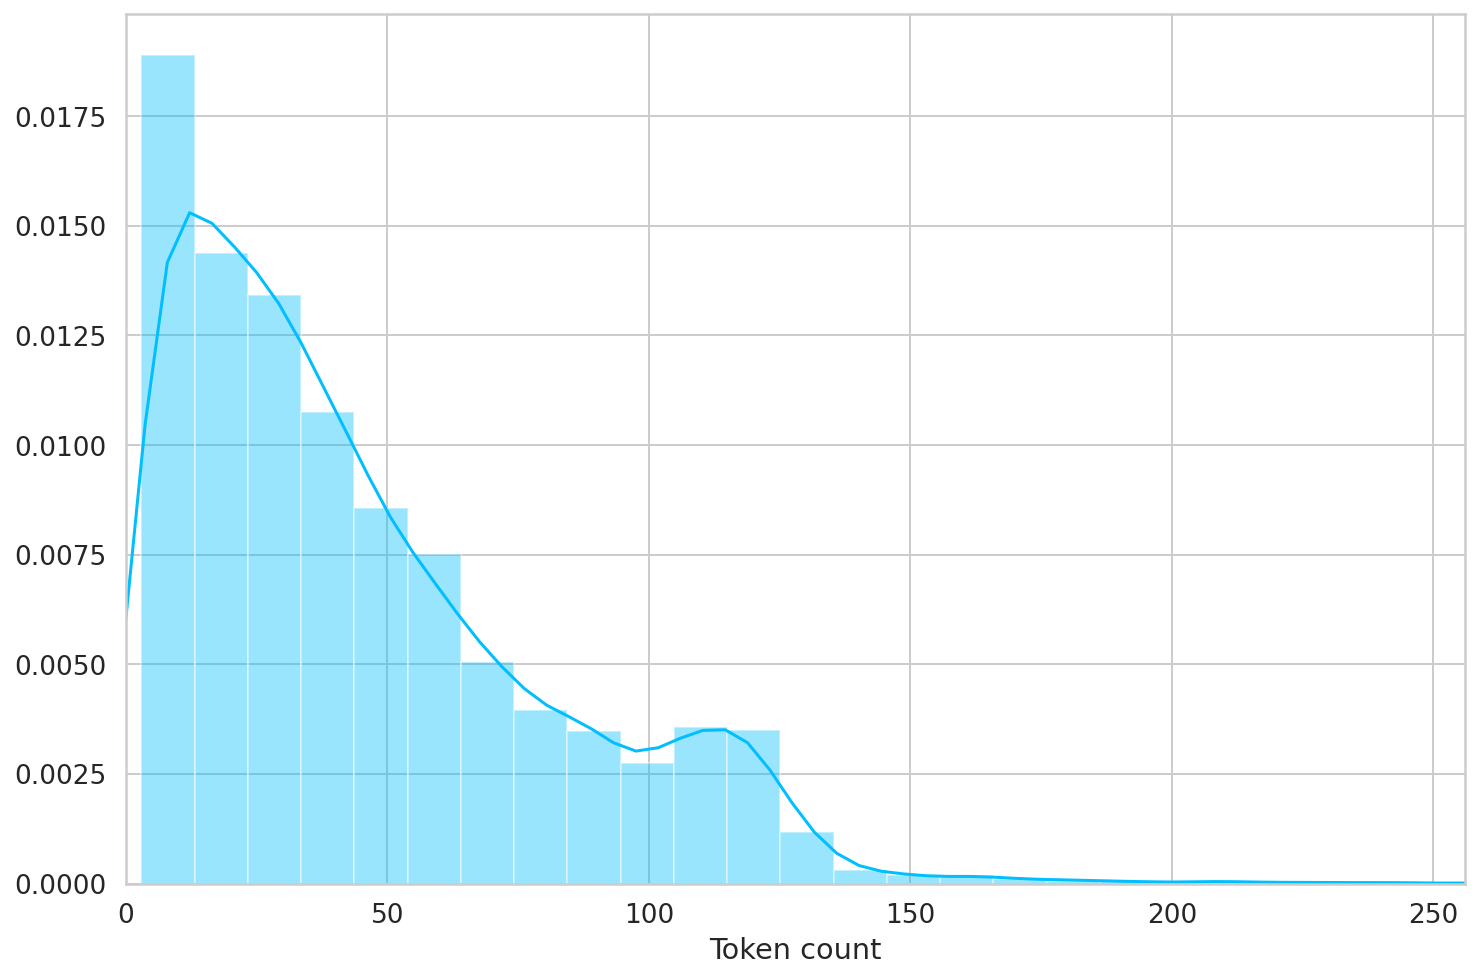

In [17]:
# 將句子長度的分布畫出來
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

### 切開訓練集與測試集
將資料集依據9:1切成 train和test，再取出test的一半，切成validation。

In [18]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

# 看一下三種資料的總筆數
print("shape of train / validation / test")
print(df_train.shape, df_val.shape, df_test.shape)

shape of train / validation / test
(14171, 12) (787, 12) (788, 12)


### 定義處理資料的物件和函數：
+ `GPReviewDataset`：
    + encoding 句子，並把預測目標轉成torch.tensor
    + 回傳`review_text`（原本句子）、`input_ids`、`attention_mask`、`targets`（情緒標籤）
+ `create_data_loader`：
    + 指定傳入的資料集中，要encode的句子和預測目標的欄位。
    + 用`DataLoader`的格式回傳`GPReviewDataset`處理後的資料

In [19]:
class GPReviewDataset(Dataset):

    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
  
    def __len__(self):
        return len(self.reviews)
  
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
          review,
          truncation=True,
          add_special_tokens=True,
          max_length=self.max_len, #句子的最大長度
          padding='max_length',
          return_token_type_ids=False,
          return_attention_mask=True,
          return_tensors='pt',
        )

        return {
          'review_text': review,
          'input_ids': encoding['input_ids'].flatten(), # encode 完之後的 token id
          'attention_mask': encoding['attention_mask'].flatten(), # encode 完之後的 attention mask
          'targets': torch.tensor(target, dtype=torch.long)
        }

In [20]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    # ds：GPReviewDataset 處理後的回傳結果
    ds = GPReviewDataset(
        reviews=df.content.to_numpy(), # 要預測的句子
        targets=df.sentiment.to_numpy(), # 要預測的目標
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )

利用上面定義的 function 處理資料物件，再定義其他基本參數：
+ `BATCH_SIZE`：一次更新要處理幾個句子
+ `MAX_LEN`：一個句子多長

補充：
+ epoch = 1 = (全部訓練樣本/batchsize)/iteration
+ 一次迭代（一個epoch），會跑過所有的訓練句子
+ batchsize 越大，要iteration的次數越少，模型訓練速度越快，不過batchsize太大，可能會導致準確率下降

In [21]:
BATCH_SIZE = 16 
MAX_LEN = 160

# 處理 train / validation / test 的 data loader
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

我們拿 train 的資料來看看處理完的結果，data裡的key就是剛才`GPReviewDataset`最後return的結果。
+ `review_text`：要預測的句子
+ `input_ids`：句子中的 token ID
+ `attention_mask`：句子中要 attention 的位置
+ `targets`：預測的目標

In [22]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

一次更新會處理的資料shape，句子的部分就是`BATCH_SIZE * MAX_LEN`，預測的情緒標籤只有一維，長度等於`BATCH_SIZE`

In [23]:
# sahpe = (BATCH_SIZE * MAX_LEN)
print(data['input_ids'].shape)
print(data['attention_mask'].shape)

# sahpe = BATCH_SIZE
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


## 3.1 下載BERT預訓練模型

這邊依據`2.2`定義的預訓練模型類型（PRE_TRAINED_MODEL_NAME），會從Transformers library上面下載最基本的 [Bert 模型](https://huggingface.co/transformers/model_doc/bert.html#bertmodel)，在此只下載BERT轉換字詞向量的方式，後續自行定義下游的分類任務。不過Transformers也提供不同任務，設計的包裝好的model，可以參考以下的連結。

+ 句子分類：[BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification)
+ QA任務：[BertForQuestionAnswering](https://huggingface.co/transformers/model_doc/bert.html#bertforquestionanswering)

我們拿剛剛的範例句子的encode結果（my my dear friend那句），套用到模型裡面看看會有甚麼結果

In [24]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME) # 上面定義的 'bert-base-cased'
bert_encode_output = bert_model(
    input_ids=encoding['input_ids'], 
    attention_mask=encoding['attention_mask']
)

# bert 用來代表每個字的維度
print(f"vector size: {bert_model.config.hidden_size}")  
# bert model 最後一層 layer output 的 sahpe (data_size * max_length * hidden_size)
print(f"shape of last output: {bert_encode_output.last_hidden_state.shape}")
# bert model 最後一層 layer 的 shape
print(f"shape of last layer: {bert_encode_output.pooler_output.shape}")  

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vector size: 768
shape of last output: torch.Size([1, 32, 768])
shape of last layer: torch.Size([1, 768])


## 3.2 定義完整模型與訓練、驗證流程

### 定義完整模型
上面下載的預訓練模型，還需要搭配下游任務的其他神經網路層，才能組成一個完整的分類任務架構，用 BERT取出訓練資料的代表向量後，後面再加上一層dropout，最後用一層線性layer，把bert最後一層的hidden state 768維的向量轉為3維，方便後續做分類。

In [25]:
class SentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        # 定義會用到的方法
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME) #bert model
        self.drop = nn.Dropout(p=0.3) # dropout layer
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes) # layer sahpe, 預測幾類
  
    def forward(self, input_ids, attention_mask):
        # 把上面定義的方法串起來
        model_output = self.bert( 
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        output = self.drop(model_output.pooler_output)
        
        return self.out(output)

定義完模型`SentimentClassifier`後，我們用`.to(device)`把模型都移到GPU上面

In [26]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


訓練資料也移到GPU上面，shape會是 BATCH_SIZE(一次更新的句數) * MAX_LEN(一句話的最長長度)

In [27]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


### softmax 轉換
模型最後一層linear layer將產出的向量轉為3維後，需要再經過一層`softmax layer`轉換，讓最後一層輸出的總和為1，套用到我們的例子，就是讓最後一層預測三種情緒的機率總和為1。

+ softmax 補充：[相關連結](https://medium.com/手寫筆記/使用-tensorflow-學習-softmax-回歸-softmax-regression-41a12b619f04)

In [28]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.2332, 0.4717, 0.2951],
        [0.2219, 0.3612, 0.4168],
        [0.3589, 0.2427, 0.3984],
        [0.2221, 0.3218, 0.4561],
        [0.5762, 0.2056, 0.2181],
        [0.2249, 0.4422, 0.3329],
        [0.2750, 0.3181, 0.4069],
        [0.3732, 0.2454, 0.3813],
        [0.3927, 0.1892, 0.4181],
        [0.3349, 0.1948, 0.4703],
        [0.3043, 0.2263, 0.4695],
        [0.3710, 0.1894, 0.4396],
        [0.2090, 0.4449, 0.3462],
        [0.3396, 0.2594, 0.4010],
        [0.3456, 0.2260, 0.4284],
        [0.1500, 0.3302, 0.5198]], device='cuda:0', grad_fn=<SoftmaxBackward>)

### 定義訓練流程
這裡我們設定要迭代（epoch，模型完整跑過整個資料集）的次數，與訓練模型時的優化器`optimizer`，優化器能決定模型更新參數的方法，在這裏使用AdamW，有興趣的同學可以測試其他的優化器效果。另外這裡定義損失函數（loss function）為我們的目標函數（objective function），亦即每次模型每次更新參數，都要以最小化損失函數為目標，讓模型整體預測出的機率越接近真實標籤的值越好。

補充連結
+ [optimizer](https://ithelp.ithome.com.tw/articles/10236554)
+ [目標函數介紹](https://chih-sheng-huang821.medium.com/機器-深度學習-基礎介紹-損失函數-loss-function-2dcac5ebb6cb)

In [29]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

我們將之前定義的函數整理成訓練流程
1. 將資料都移到GPU上面
2. 將encode後的input_ids和attention_mask放入分類任務的模型，並取出預測每個類別資料的機率
3. 取出預測最大值，並利用損失函數計算模型的loss
4. 利用3計算出的loss更新模型參數，為了防止更新時的梯度爆炸，另外限制梯度的最大值

In [30]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
    model = model.train()

    losses = []
    correct_predictions = 0
  
    for d in data_loader:
        # 1.把訓練資料放到 GPU 上
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        # 2.拿出模型預測結果(預測各類別的機率)
        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        
        # 3 取出預測機率的最大值，當作最終預測類別
        _, preds = torch.max(outputs, dim=1)
        # 比較預測機率和真實標籤的差異算loss
        loss = loss_fn(outputs, targets)
        
        # 計算正確預測的數量，並儲存loss
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        # 4. 更新模型參數
        loss.backward()
        # 為了避免梯度爆炸，將梯度限制在１以內
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

### 定義驗證流程
另外定義驗證模型準確度的部分，主要是計算模型的loss和預測正確的數量，但不會更新模型參數
1. 將資料都移到GPU上面
2. 將encode後的input_ids和attention_mask放入分類任務的模型，並取出預測每個類別資料的機率
3. 取出預測最大值，並利用損失函數計算模型的loss

In [31]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            # 1.把訓練資料放到 GPU 上
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # 2.拿出模型預測結果(預測各類別的機率)
            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            
            # 3 取出預測機率的最大值，當作最終預測類別
            _, preds = torch.max(outputs, dim=1)
            # 比較預測機率和真實標籤的差異算loss
            loss = loss_fn(outputs, targets)
            # 計算正確預測的數量，並儲存loss
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

## 3.3 迭代訓練模型
訓練和驗證的部分都定義好之後，就可以把全部的東西串起來了！接下來依據上面設定的迭代次數，計算模型每一次迭代的準確率與loss的變化。另外在迭代的過程中，會紀錄最佳的迭代次數，最後會選準確率最佳的模型。
1. 取得每次迭代模型的準確率和loss
2. 取得每次迭代模型，驗證資料的準確率和loss
3. 儲存每次迭代訓練、驗證集的準確率和loss

In [35]:
%%time
t = time()

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    
    # 1.取得每次迭代模型，訓練資料的準確率和loss
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,    
        loss_fn, 
        optimizer, 
        device, 
        scheduler, 
        len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')
    
    # 2.取得每次迭代模型，驗證資料的準確率和loss
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn, 
        device, 
        len(df_val)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    
    # 3. 儲存每次迭代訓練、驗證集的準確率和loss
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    # 以驗證集的準確率為標準，儲存最佳的模型
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc
        
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Epoch 1/10
----------
Train loss 0.6522913610827573 accuracy 0.7199915320019759
Val   loss 0.5526198737323285 accuracy 0.770012706480305

Epoch 2/10
----------
Train loss 0.3747674386347087 accuracy 0.8626067320584292
Val   loss 0.5389933307468892 accuracy 0.8221092757306226

Epoch 3/10
----------
Train loss 0.21475086150518524 accuracy 0.9321854491567285
Val   loss 0.6204063127376139 accuracy 0.8576874205844981

Epoch 4/10
----------
Train loss 0.14359411679754353 accuracy 0.958789076282549
Val   loss 0.7625465900218115 accuracy 0.8703939008894537

Epoch 5/10
----------
Train loss 0.1096217889442139 accuracy 0.9706442735163362
Val   loss 0.7730615636659786 accuracy 0.878017789072427

Epoch 6/10
----------
Train loss 0.08048524664724524 accuracy 0.9782654717380567
Val   loss 0.7986682084132917 accuracy 0.8742058449809403

Epoch 7/10
----------
Train loss 0.057870106860985704 accuracy 0.9831345706019335
Val   loss 0.8930581047630404 accuracy 0.8716645489199493

Epoch 8/10
----------
Tra

### 檢視訓練結果
訓練完成後將各epoch的準確率和loss畫出來，發現訓練集的資料很早就達到近乎百分之百的準確率，但驗證集的資料到一定的迭代次數後就沒有顯著的上升，以此推估測試集的準確率大概會在0.87左右。

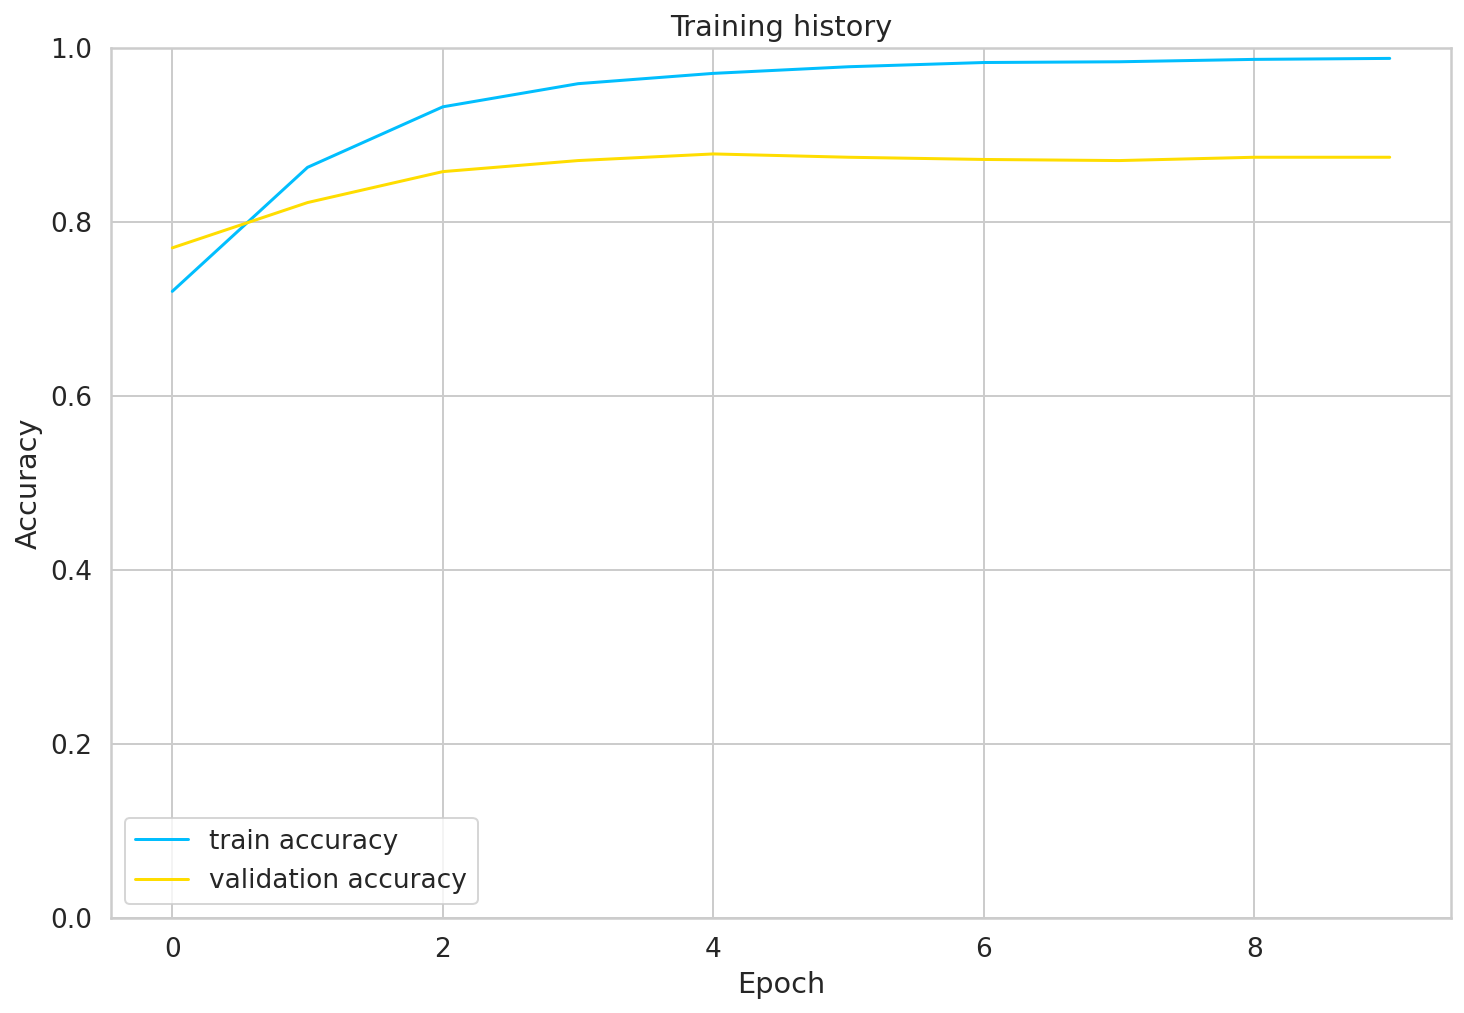

In [40]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

## 4.1 檢視總體訓練結果

也可以從這裡直接下載已經訓練好的模型，再放到指定的資料夾

In [ ]:
# 下載雲端硬碟上已經訓練好的模型
# !gdown --id 1NJ6HDA5YL4E2rcj6ulRTmduwUsUC5mzG

In [41]:
model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('model/en/best_model_state.bin'))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### 預測訓練集資料
我們將訓練好的模型套入驗證資料集，查看準確率，大概有0.88，和上面訓練驗證集的準確率差不多。可以持續調整其他參數試試看會不會獲得更好的結果。

In [45]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

print(f"accuracy of test data: {test_acc.item()}")

accuracy of test data: 0.881979695431472


### 定義取出訓練結果的函數
+ 輸入：
    + `model`：訓練好的模型
    + `data_loader`：要預測的資料
+ 輸出：
    + `review_texts`：要預測的資料
    + `predictions`：預測結果
    + `prediction_probs`：預測機率
    + `real_values`：真實標籤

+ 取出預測結果
    1. 把訓練資料放到 GPU 上
    2. 拿出模型預測結果(預測各類別的機率)
    3. 取出預測機率的最大值，當作最終預測類別
    4. 儲存要預測的評論資料與預測結果

In [46]:
def get_predictions(model, data_loader):
    model = model.eval()
  
    review_texts = [] # 存要預測的評論
    predictions = [] # 存預測結果
    prediction_probs = [] # 存預測機率
    real_values = [] # 存真實標籤

    with torch.no_grad():
        for d in data_loader:
            # 1.把訓練資料放到 GPU 上
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # 2.拿出模型預測結果(預測各類別的機率)
            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            
            # 3. 取出預測機率的最大值，當作最終預測類別
            _, preds = torch.max(outputs, dim=1)
            probs = F.softmax(outputs, dim=1)
            
            # 4. 儲存要預測的評論資料與預測結果
            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [49]:
# 取出測試集的預測結果
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

### 檢視預測結果
首先檢視各個類別的`precision`,`recall`,`f1-score`，看起來中性和負面的評論表現較差

In [50]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.90      0.84      0.87       245
     neutral       0.84      0.86      0.85       254
    positive       0.91      0.93      0.92       289

    accuracy                           0.88       788
   macro avg       0.88      0.88      0.88       788
weighted avg       0.88      0.88      0.88       788



查看各個類別的混淆矩陣，發現正面和負面的評論混淆成中性的情況較多，中性的評論也常混淆成這兩者。

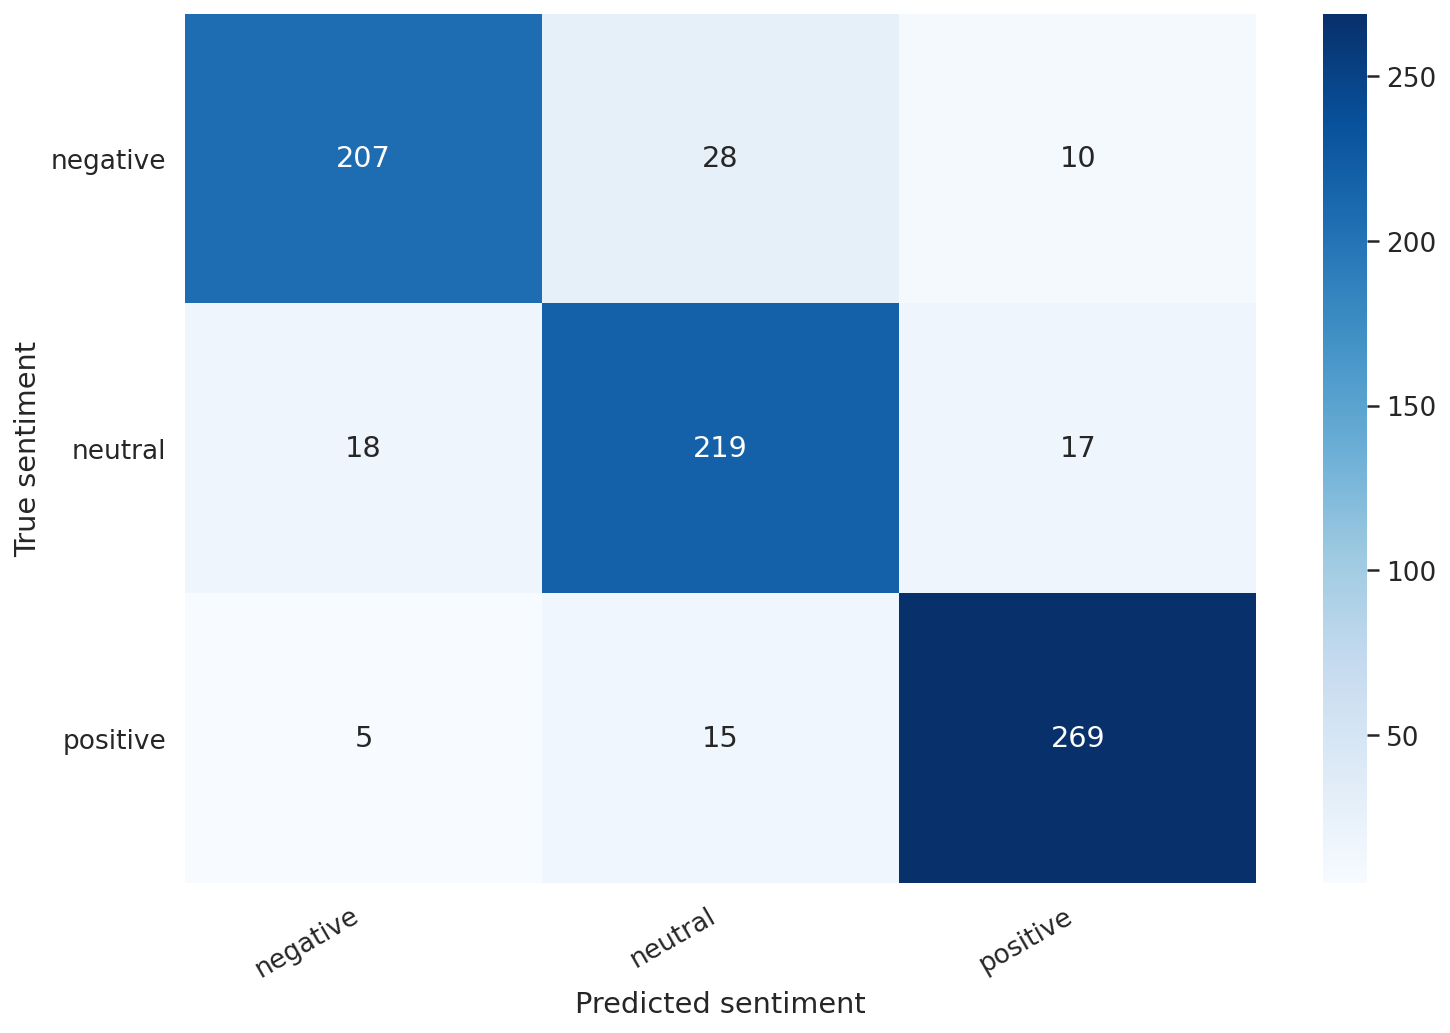

In [53]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

## 4.2 個別句子的預測分析
看完總體的預測結果，我們挑出幾筆資料單獨看預測的結果。

In [72]:
# 拿測試資料集的第三筆資料
idx = 2
review_text = y_review_texts[idx] # 要預測的資料
true_sentiment = y_test[idx] # 真實標籤

# 將預測結果整合成dataframe
pred_df = pd.DataFrame({
  'class_names': class_names, # 三種情緒標籤
  'values': y_pred_probs[idx] # 單筆預測機率
})
pred_df

,class_names,values
0,negative,0.000251
1,neutral,0.999507
2,positive,0.000241


In [73]:
print("original text: ")
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

original text: 
I used to use Habitica, and I must say this is a great step up. I'd
like to see more social features, such as sharing tasks - only one
person has to perform said task for it to be checked off, but only
giving that person the experience and gold. Otherwise, the price for
subscription is too steep, thus resulting in a sub-perfect score. I
could easily justify $0.99/month or eternal subscription for $15. If
that price could be met, as well as fine tuning, this would be easily
worth 5 stars.

True sentiment: neutral


### 機率長條圖
將單筆資料預測各個類別的機率化成長條圖，看起來對這筆資料模型預測的滿準的

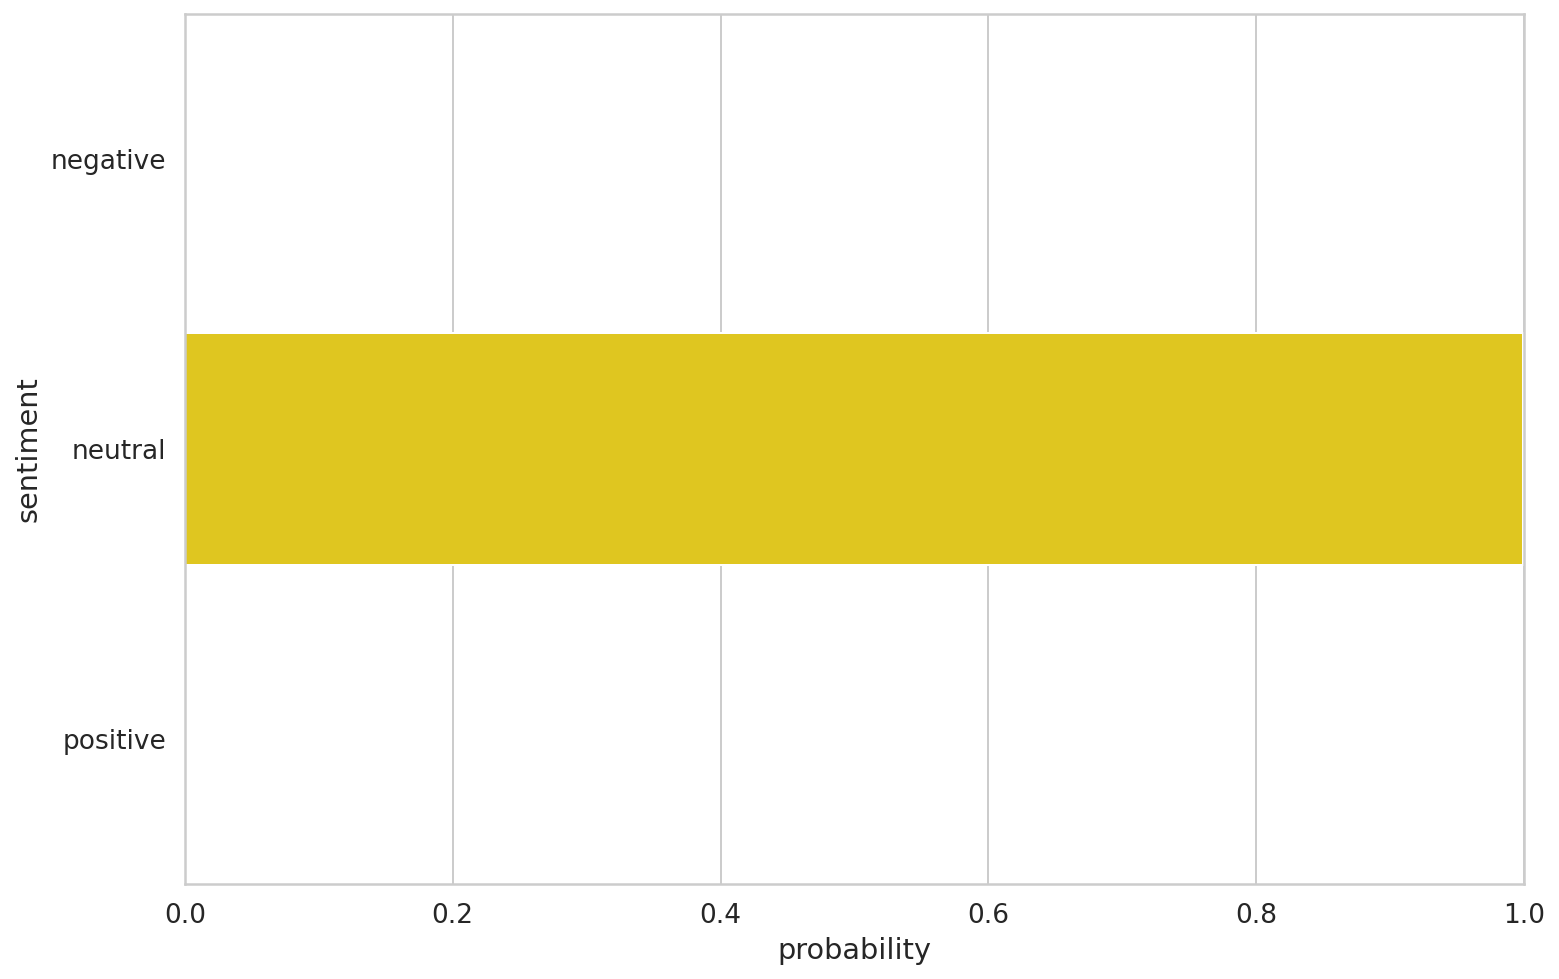

In [75]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

### 預測自定的新句子
除了data_loder載入的資料集，也可以自己輸入新句看預測結果。

In [76]:
review_text = "I love completing my todos! Best app ever!!!"

In [77]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/ann2/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [78]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I love completing my todos! Best app ever!!!
Sentiment  : positive


## 結論
1. 如何建構一個完整的BERT模型
    + 將資料分為訓練、驗證與測試資料集：訓練集用來更新模型參數、驗證集可檢驗迭代過程中模型的訓練效果，最後將訓練模型套用在測試集上預測結果。
    + 先將資料轉換為 token_ID 與 attention_mask 再送入模型作訓練
    + 可從 Transformer library 下載預訓練好的模型，再自行定義下游任務作預測
    + 經由迭代的過程更新模型參數，並儲存效果最佳的模型
2. 什麼樣的類別預測的效果較好？
    + 正面類別的資料預測效果最好，中性資料則容易混淆成其他兩類情緒

## 相關連結
+ 教學影片
    + Text Preprocessing 資料前處理
    + https://www.youtube.com/watch?v=Osj0Z6rwJB4
    + Text Classification 分類任務
    + https://www.youtube.com/watch?v=8N-nM3QW7O0        
+ 套件
    + transformers 官網
    + https://huggingface.co/docs/transformers/index
+ 參考教材：
    + Sentiment Analysis with BERT
    + https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/?fbclid=IwAR2hFMfTqG7ielGSfrtzEbUIH7EPXNOLG3dIQidMwiOh-wISSWL-sYf8Yhg